In [57]:
from data_loader import load_latest_iteration, find_latest_vtu_files

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [58]:
mode = "hard"
FOLDER = f"../demo/cpp/hard/build/src/vtk_output_{mode}/data"

data = load_latest_iteration(FOLDER)

Latest iteration 0 is not the same as the global latest iteration 45


In [59]:
particles = data["particles"]
parameters = data["parameters"]

In [60]:
particles.drop("lengths_y", axis=1, inplace=True)
particles.drop("lengths_z", axis=1, inplace=True)
particles.rename(columns={"lengths_x": "length"}, inplace=True)

In [61]:
def spherocylinder_area(length, radius=0.5):
    """Calculate area of a spherocylinder with given length and radius"""
    return np.pi * radius**2 + 2 * radius * length

def plot_radial_distribution(particles, variable, bin_size=1, fig=None):
    """
    Plot radial distribution of a variable.

    Args:
        particles: DataFrame containing particle data
        variable: String name of the variable to analyze or 'packing_fraction'
        bin_size: Size of radial bins
        fig: Optional figure to plot on
    """
    # Calculate radial distances
    particles["dist_center"] = np.sqrt(
        particles["x"]**2 + particles["y"]**2 + particles["z"]**2)

    # Create radial bins
    max_radius = int(particles["dist_center"].max())
    r_edges = np.arange(0, max_radius + bin_size, bin_size)
    r_centers = (r_edges[1:] + r_edges[:-1]) / 2

    # Calculate values in each shell
    var_vals = []
    for i in range(len(r_centers)):
        mask = (particles["dist_center"] >= r_edges[i]) & (
            particles["dist_center"] < r_edges[i+1])
        shell_particles = particles[mask]
        
        if variable == 'packing_fraction':
            if len(shell_particles) > 0:
                # Calculate total area of particles in shell
                total_particle_area = sum(spherocylinder_area(length)
                                        for length in shell_particles["length"])
                # Calculate area of the shell
                shell_area = np.pi * (r_edges[i+1]**2 - r_edges[i]**2)
                # Calculate packing fraction
                val = total_particle_area / shell_area
            else:
                val = 0
        else:
            val = shell_particles[variable].mean() if len(shell_particles) > 0 else 0
            
        var_vals.append(val)

    var_vals = np.array(var_vals)

    # Create or get figure
    if fig is None:
        fig = plt.figure(figsize=(8, 5))
        ax = fig.add_subplot(111)
    else:
        ax = fig.axes[0]

    # Plot variable distribution
    label = "Packing fraction" if variable == 'packing_fraction' else variable
    ax.plot(r_centers, var_vals, "o-", label=label)
    ax.set_xlabel("Radius")
    ax.set_ylabel(label)
    ax.set_title(f"Radial Distribution of {label}")
    ax.grid(True)
    ax.legend()

    fig.savefig(f"radial_distribution_{mode}_{variable}.png")

    return fig, r_centers, var_vals

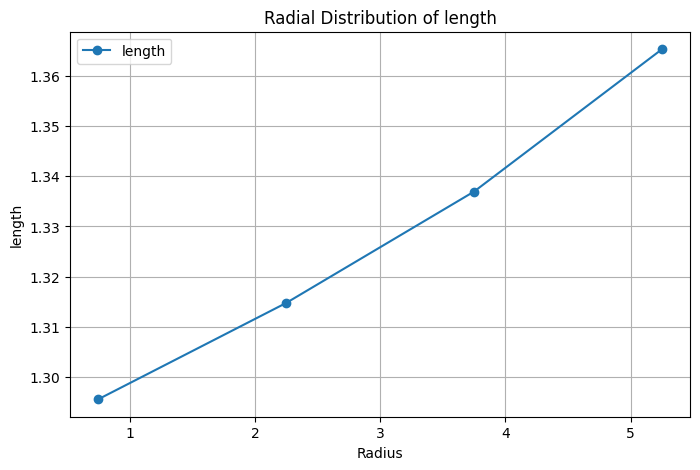

In [62]:
_= plot_radial_distribution(particles, "length", bin_size=1.5)

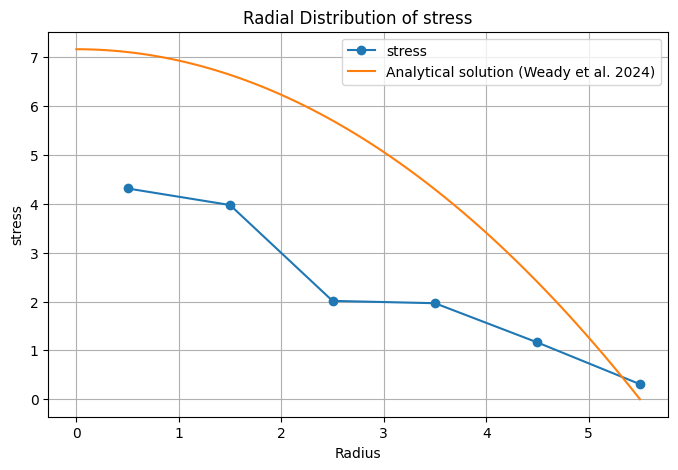

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


fig, bin_centers, avg_val = plot_radial_distribution(particles, "stress")


def pressure_theoretical(r, R, LAMBDA):
    c = (np.sqrt((1 + LAMBDA * R**2 / 2)) - 1) / (2 * LAMBDA * R**2)

    return 2 / LAMBDA * np.log(1/(8*c) - c * LAMBDA * r**2)


r = np.linspace(0, bin_centers[-1], 100)

ax_stress = fig.axes[0]
ax_stress.plot(r, pressure_theoretical(r, bin_centers[-1], data["parameters"]["LAMBDA"][0]),
               label="Analytical solution (Weady et al. 2024)")
ax_stress.legend()

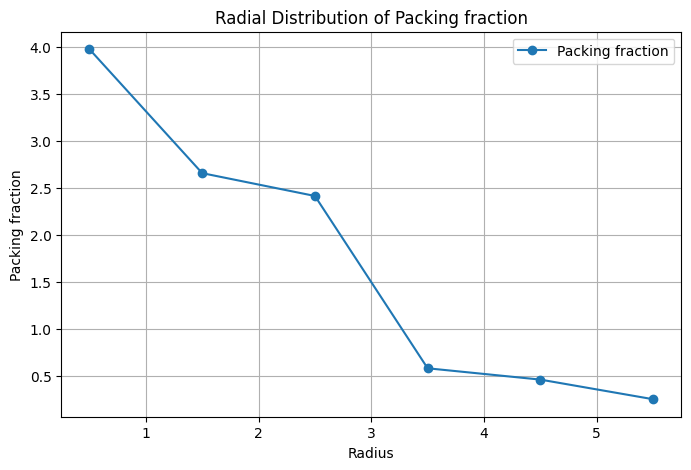

In [64]:
fig, r_centers, packing_fractions = plot_radial_distribution(particles, 'packing_fraction', bin_size=1)